In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from itertools import repeat
import matplotlib.patches as patches
import matplotlib.lines as lines

In [2]:
aaconv = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M',
     'H1S': 'H', 'H2S': 'H'}

In [3]:
protein_length = 510
genecolour ="#656565"

In [4]:
clusteringresults = pd.read_csv("../Data/Mutation_clustering/FH_1D_mutationclusters.csv", sep = " ")

In [5]:
clusteringresults.head()

,cluster_size,start,end,number,p_value
X232,4,232,235,28,1.410696e-28
X231,5,231,235,30,5.052820e-28
X235,1,235,235,20,1.046176e-27
X231,7,231,237,31,2.235644e-24
X232,6,232,237,29,4.282449e-24


In [6]:
# Drop clusters that are too small or large
significant_clusters = clusteringresults[(clusteringresults["cluster_size"] < 50) & (clusteringresults["cluster_size"] > 2)]

In [7]:
# Keep only the first cluster (most significant) starting at each residue - otherwise top 30 are all around 232
significant_clusters_first = significant_clusters.drop_duplicates(subset="start", keep= "first")

In [8]:
significant_clusters_first = significant_clusters_first.head(5)

## Read in mutation file

In [9]:
mutationfile = pd.read_excel("../Data/Mutations_database/FH_mutations_DB.xlsx")

## Get rid of benign mutations

In [10]:
mutationfile_nonbenign = mutationfile[mutationfile["Clinical Class"] != "benign"]
mutationfile_nonbenign = mutationfile_nonbenign[mutationfile_nonbenign["Clinical Class"] != "likely benign"]


In [11]:
mutationfile_nonbenign.head()

,Effect,Exon,DNA Change,Clinical Class,RNA Change,Protein Change,SIFT,Predicted,DNA Change (hg19),DNA Change (hg38),...,Reference,ClinVar ID,dbSNP ID,Origin,Segregation,Frequency,Re-site,VIP,Methylation,Owner
0,?/-,1,c.-11C>T,-,r.(=),p.(=),0,-,g.241683033G>A,g.241519733G>A,...,PubMed: Lehtonen,-,-,Germline,-,-,-,0,-,Jean-Pierre Bayley
1,?/?,1,c.-11C>T,-,r.(=),p.(=),0.01,-,g.241683033G>A,g.241519733G>A,...,-,-,-,Unknown,-,-,-,0,-,Audrey Remenieras
2,?/-?,1,c.105G>A,-,r.(=),p.(=),-,-,g.241682918C>T,g.241519618C>T,...,-,-,-,Unknown,-,-,-,0,-,Audrey Remenieras
3,-/-?,1i,c.132+71C>A,-,r.(=),p.(=),-,-,g.241682820G>T,g.241519520G>T,...,-,-,-,Unknown,-,-,-,0,-,Audrey Remenieras
4,-/-?,1i,c.132+71C>A,-,r.(=),p.(=),-,-,g.241682820G>T,g.241519520G>T,...,-,-,-,Unknown,-,-,-,0,-,Audrey Remenieras


## Process to get mutation list

In [12]:
mutationlist_only = pd.DataFrame(mutationfile["Protein Change"])
mutationlist_only['A'], mutationlist_only['Mutation'] = mutationlist_only['Protein Change'].str.split('p.', 1).str
mutationlist_only = mutationlist_only[mutationlist_only["Mutation"] != "?"]
mutationlist_only = mutationlist_only[mutationlist_only["Mutation"] != "(=)"]

In [13]:
mutationlist_only["Mutation"] = mutationlist_only.apply(lambda x: x["Mutation"][1:-1], axis =1)
mutationlist_only = mutationlist_only[~mutationlist_only.Mutation.str.contains("\*")]
mutationlist_only = mutationlist_only[~mutationlist_only.Mutation.str.contains("dup")]
mutationlist_only = mutationlist_only[~mutationlist_only.Mutation.str.contains("del")]
mutationlist_only["AAfrom"] = mutationlist_only.apply(lambda x: x["Mutation"][:3], axis =1)
mutationlist_only["AAto"] = mutationlist_only.apply(lambda x: x["Mutation"][-3:], axis =1)
mutationlist_only["Residue"] = mutationlist_only.apply(lambda x: int(x["Mutation"][3:-3]), axis =1)
mutationlist_only = mutationlist_only[mutationlist_only["Residue"] >= 49]
mutationlist_only["AAfrom"] = mutationlist_only["AAfrom"].apply(lambda x: aaconv.get((x.upper())))
mutationlist_only["AAto"] = mutationlist_only["AAto"].apply(lambda x: aaconv.get((x.upper())))
mutationlist_only["Mutation"] = mutationlist_only.apply(lambda x: "%s%s%s" % (x["AAfrom"], (x["Residue"]), x["AAto"] ), axis =1)
mutationlist_original = []
for item in mutationlist_only["Mutation"]:
    mutationlist_original.append(item)
mutationlist = mutationlist_original

In [14]:
mutationdataframe = pd.DataFrame(mutationlist, columns = ["Mutation"])
count_series = mutationdataframe.groupby(['Mutation']).size()
mutation_frequencyframe = count_series.to_frame(name = 'Counts').reset_index()
mutation_frequencyframe = mutation_frequencyframe.sort_values("Counts", ascending = False)

## Generate mutation dataframe entry for each mutation

In [15]:
mutation_frequencyframe["Residue"] = mutation_frequencyframe["Mutation"].apply(lambda x: x[1:-1])

In [16]:
mutation_frequencyframe.head()

,Mutation,Counts,Residue
81,R233H,9,233
80,R233C,9,233
59,N107T,9,107
41,K230R,8,230
30,G397R,7,397


In [17]:
mutation_frequencyframe[mutation_frequencyframe["Residue"] == "233"]

,Mutation,Counts,Residue
81,R233H,9,233
80,R233C,9,233
82,R233L,2,233


In [18]:
mutation_frequencyframe_only = mutation_frequencyframe[["Mutation", "Residue"]]

In [19]:
mutationcount_aggregate = mutation_frequencyframe.groupby(["Residue"]).sum()

In [20]:
mutation_frequencyframe = mutation_frequencyframe_only.merge(mutationcount_aggregate, on = "Residue")

## Merge all counts into one

In [21]:
mutation_frequencyframe.head()

,Mutation,Residue,Counts
0,R233H,233,20
1,R233C,233,20
2,R233L,233,20
3,N107T,107,10
4,N107I,107,10


In [22]:
mutation_max = max(mutation_frequencyframe["Counts"])
#Get max value for the plot

## Combine labels

In [23]:
mutationcountlist = []
mutationlist = mutation_frequencyframe["Mutation"].unique()
for residue in mutation_frequencyframe["Residue"]:
    mutationframe = (mutation_frequencyframe.loc[mutation_frequencyframe["Residue"] == residue])
    mutationlist = mutationframe["Mutation"].unique()
    mutationcountlist.append((mutationlist.tolist(), int(mutation_frequencyframe.loc[mutation_frequencyframe["Residue"] == residue]["Counts"].values[0]), residue))

In [24]:
mutationcountlist

[(['R233H', 'R233C', 'R233L'], 20, '233'),
 (['R233H', 'R233C', 'R233L'], 20, '233'),
 (['R233H', 'R233C', 'R233L'], 20, '233'),
 (['N107T', 'N107I'], 10, '107'),
 (['N107T', 'N107I'], 10, '107'),
 (['K230R'], 8, '230'),
 (['G397R'], 7, '397'),
 (['A117P'], 7, '117'),
 (['H318Y', 'H318L'], 6, '318'),
 (['H318Y', 'H318L'], 6, '318'),
 (['P174R'], 5, '174'),
 (['H196R'], 4, '196'),
 (['G282V'], 3, '282'),
 (['H180R'], 3, '180'),
 (['N188S'], 3, '188'),
 (['D216E'], 3, '216'),
 (['Y465C'], 3, '465'),
 (['C333Y'], 3, '333'),
 (['Q376P'], 3, '376'),
 (['N361K'], 2, '361'),
 (['N340K'], 2, '340'),
 (['Q386R'], 2, '386'),
 (['L453P'], 2, '453'),
 (['S171N'], 2, '171'),
 (['I229T'], 2, '229'),
 (['S334R'], 2, '334'),
 (['S365G'], 2, '365'),
 (['S366N'], 2, '366'),
 (['N373S', 'N373D'], 3, '373'),
 (['N373S', 'N373D'], 3, '373'),
 (['M195V', 'M195T'], 3, '195'),
 (['M195V', 'M195T'], 3, '195'),
 (['G275E'], 2, '275'),
 (['C434Y'], 2, '434'),
 (['D425V'], 2, '425'),
 (['D341N', 'D341G', 'D341Y']

In [25]:
processed_dataframe = pd.DataFrame(mutationcountlist,columns=['Mutations', 'Count', "Residue"])

In [26]:
processed_dataframe = processed_dataframe.drop_duplicates(subset = "Residue")

In [27]:
processed_dataframe = pd.DataFrame(mutationcountlist,columns=['Mutations', 'Count', "Residue"])
processed_dataframe["Mutations"] = processed_dataframe["Mutations"].apply(lambda x: x[0] +"/"+ x[1][-1] if len(x) >1 else x[0])
processed_dataframe= processed_dataframe.drop_duplicates()

In [28]:
processed_dataframe

,Mutations,Count,Residue
0,R233H/C,20,233
3,N107T/I,10,107
5,K230R,8,230
6,G397R,7,397
7,A117P,7,117
...,...,...,...
103,M368T,1,368
104,L507P,1,507
105,E126D,1,126
106,L335P,1,335


In [29]:
processed_dataframe.to_csv("./FH_mutation_frequencyframe.csv")

In [30]:
# Only consider mutations with > 4 entries for labelling
mutationfrequencyframe_sig = processed_dataframe[processed_dataframe['Count'] >= 4]

In [31]:
mutationfrequencyframe_sig

,Mutations,Count,Residue
0,R233H/C,20,233
3,N107T/I,10,107
5,K230R,8,230
6,G397R,7,397
7,A117P,7,117
8,H318Y/L,6,318
10,P174R,5,174
11,H196R,4,196
35,D341N/G,4,341


In [32]:
# Generate a mutationlist for the countplot
mutationlist = []
for index, columns in processed_dataframe.iterrows():
    mutationlist.extend(repeat(int(columns["Residue"]), int(columns["Count"])))
    
print(mutationlist)

[233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 233, 107, 107, 107, 107, 107, 107, 107, 107, 107, 107, 230, 230, 230, 230, 230, 230, 230, 230, 397, 397, 397, 397, 397, 397, 397, 117, 117, 117, 117, 117, 117, 117, 318, 318, 318, 318, 318, 318, 174, 174, 174, 174, 174, 196, 196, 196, 196, 282, 282, 282, 180, 180, 180, 188, 188, 188, 216, 216, 216, 465, 465, 465, 333, 333, 333, 376, 376, 376, 361, 361, 340, 340, 386, 386, 453, 453, 171, 171, 229, 229, 334, 334, 365, 365, 366, 366, 373, 373, 373, 195, 195, 195, 275, 275, 434, 434, 425, 425, 341, 341, 341, 341, 346, 160, 350, 350, 268, 261, 274, 274, 298, 308, 101, 444, 439, 317, 385, 254, 185, 142, 51, 369, 87, 73, 435, 394, 322, 140, 381, 375, 330, 277, 419, 399, 194, 239, 258, 187, 158, 374, 192, 309, 244, 211, 132, 467, 337, 355, 362, 402, 53, 235, 312, 312, 135, 97, 69, 218, 303, 354, 315, 377, 189, 329, 310, 454, 382, 368, 507, 126, 335, 103]


In [33]:
# Convert mutationlist into the format necessary for countplots
x = range(1,protein_length)
mutantcount = []
mutantcount_nozeroes = []
for i in x:
    if mutationlist.count(i) != 0:
        mutantcount.append(mutationlist.count(i))
        mutantcount_nozeroes.append(mutationlist.count(i))
    elif mutationlist.count(i) == 0:
        mutantcount.append(-1)

## Define some functions for adding rectangles and clustering lines to the plot

In [34]:
def plotrec(x1, x2, y, name, color):
    width = abs(x2-x1)
    height = 1.25
    axes.add_patch(patches.Rectangle([x1, y], width, height, lw = 2, facecolor = color, edgecolor = "k", zorder = 100, clip_on=False))
    axes.text(x1+(width/2),-2.5, name, size = 14, clip_on=False, zorder= 101, horizontalalignment = "center", verticalalignment = "center")

In [35]:
def plotline(x1, x2, y, color):
    line = lines.Line2D([x1, x2], [y, y], lw = 3, color = color, axes = axes, clip_on=False, marker = "|", mew = 3)
    axes.add_line(line)

## Define a dictionary of the subunits of the protein for plotting

In [36]:
FH_subunits = {"D1 Subunit": [50, 188, "#43A9DB"], "D2 Subunit": [188, 440, "#FB4459"], "D3 Subunit": [440, 509, "#fffc79"]}

In [37]:
matplotlib.rcParams['figure.figsize'] = [20, 5]

/home/ds728/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


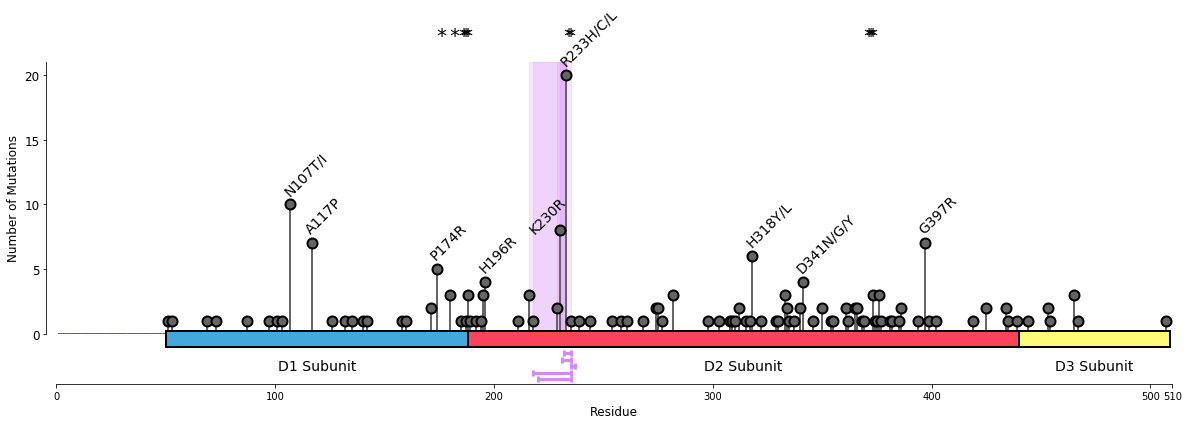

In [38]:
# Generate plot
fig = plt.figure()
axes = fig.add_subplot(111)
(markers, stemlines, baseline) = plt.stem(x, mutantcount)

sns.despine(offset = {"left":10, "bottom":50})
plt.setp(markers, markersize=10, markeredgecolor="k", markeredgewidth=2, c = genecolour, zorder = 10)
plt.setp(stemlines, color=genecolour, linewidth=2 , zorder = 5)
axes.set_ylim([0,mutation_max+1])
axes.set_xlim([0,protein_length])
axes.set_xticks([0,100,200,300,400,500,protein_length])
axes.set_yticks([0,5,10,15,20])

plt.xticks(size =10)
plt.yticks(size = 12)

# Add rectangles
for key, residues in FH_subunits.items():
        plotrec(residues[0],residues[1], -1, key, residues[2])
## Add labels - customize those labels that are overlapping
for index, row in mutationfrequencyframe_sig.iterrows():
    if row["Mutations"] == "R233H/C":
        axes.text(int(row["Residue"])-4, int(row["Count"])+0.5,"R233H/C/L", verticalalignment = "bottom", size = 14, zorder = 300, rotation = 45)
    elif row["Mutations"] == "K230R":
        axes.text(int(row["Residue"])-15, int(row["Count"])-0.5,"K230R", verticalalignment = "bottom", size = 14, zorder = 300, rotation = 45)
    elif row["Mutations"] == "D341N/G":
        axes.text(int(row["Residue"])-4, int(row["Count"])+0.5,"D341N/G/Y", verticalalignment = "bottom", size = 14, zorder = 300, rotation = 45)
    elif row["Mutations"] == "H180R":
        axes.text(int(row["Residue"])-2, int(row["Count"])+0.2,row["Mutations"], verticalalignment = "bottom", size = 14, zorder = 300, rotation = 45)
    else:
        axes.text(int(row["Residue"])-4, int(row["Count"])+0.5,row["Mutations"], verticalalignment = "bottom", size = 14, zorder = 300, rotation = 45)

plt.ylabel("Number of Mutations", size = 12)
plt.xlabel("Residue", size = 12)

## Add NMC clusters
for index,columns in significant_clusters_first.iterrows():
    plt.axvspan(columns["start"]-2, columns["end"]-2, color='#D687FC', alpha=0.2)

dist = [-1.5,-2,-2.5,-3, -3.5, -4, -5, -6, -7, -8]
count = 0
for index2, row2 in significant_clusters_first.iterrows():
        plotline(int(row2["start"]), int(row2["end"]), dist[count], '#D687FC')
        count +=1

# Add binding site annotations
for residue in [176, 182, 186, 187, 188, 234, 235, 371, 372, 373]:
    axes.text(residue,23, "*", size = 20, clip_on=False, zorder= 101, horizontalalignment = "center", verticalalignment = "center")

plt.savefig("Figure1_D_lollipop_plot.pdf", bbox_inches="tight")